In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [7]:
# Load data
df = pd.read_csv("df_combined.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)
df = df[df.index >= "2020-01-01"]

# Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Sequence Creation Function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 48
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [8]:

# Define Model for GridSearchCV
def build_model(units=64, dropout_rate=0.3):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
        Dropout(dropout_rate),
        LSTM(units // 2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(10),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
 
# Wrap the model for GridSearchCV
model = KerasRegressor(model=build_model, verbose=0)
 
# GridSearch + TimeSeriesSplit
param_grid = {
    'model__units': [32, 64, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [32, 64, 128],
    'epochs': [20, 30, 40]
}
 
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
 
# Best Model and Evaluation
best_model = grid_result.best_estimator_
print(f"✅ Best Parameters: {grid_result.best_params_}")


# Predictions
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(
    np.hstack((predictions.reshape(-1, 1), np.zeros((len(predictions), scaled_data.shape[1] - 1))))
)[:, 0]

# Convert actual values back to original scale
y_test_actual = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_data.shape[1] - 1))))
)[:, 0]

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\Utilisateur\Documents\GitHub\ML-Project\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Utilisateur\Documents\GitHub\ML-Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Best Parameters: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__units': 128}


📊 Evaluation Metrics:
✅ MAE: 5.75
✅ RMSE: 9.23
✅ MAPE: 326624730041.60%


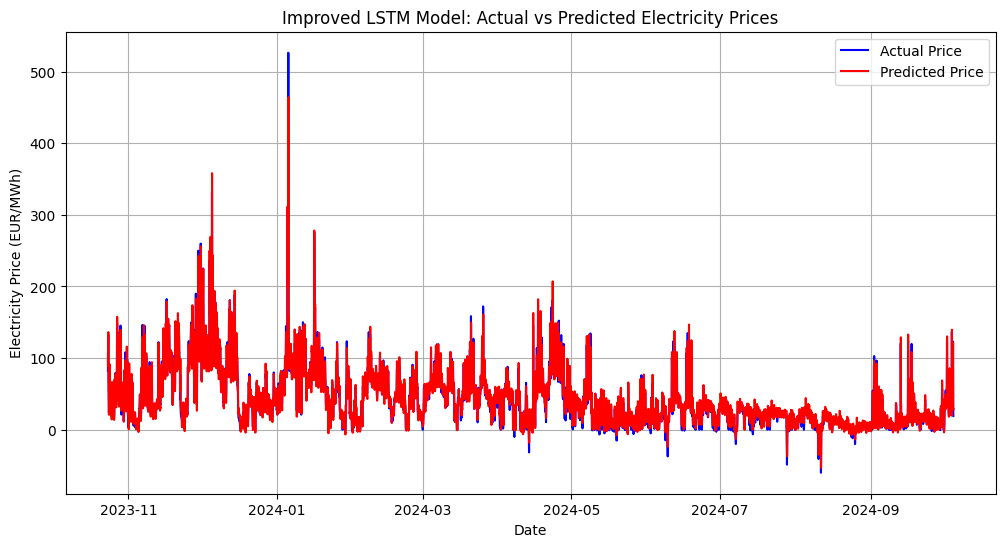

In [9]:
# Evaluation Metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
epsilon = 1e-10
mape = np.mean(np.abs((y_test_actual - predictions) / np.clip(y_test_actual, epsilon, None))) * 100

print(f"📊 Evaluation Metrics:")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Price', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predicted Price', color='red')
plt.xlabel("Date")
plt.ylabel("Electricity Price (EUR/MWh)")
plt.title("Improved LSTM Model: Actual vs Predicted Electricity Prices")
plt.legend()
plt.grid(True)
plt.show()